In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch, json
import random
import numpy as np
import tqdm
from utils_batch import InfillingModel
from torch.nn.functional import log_softmax
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

device = "cuda" if torch.cuda.is_available() else "cpu" # for GPU usage or "cpu" for CPU usage

In [5]:
def plot_roc_curve(human_scores, gpt_scores):
    # Data
    A, B = human_scores, gpt_scores
    # Combine scores and true labels
    scores = A + B
    labels = [0] * len(A) + [1] * len(B)
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(labels, scores)
    # Calculate AUC (Area Under Curve)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve: Open-gen w/ GPT3.5-Reddit w prompts' )
    plt.legend(loc="lower right")
    plt.show()
    # what is the TPR for FPR = 0.1?
    for idx, fpr_ in enumerate(fpr):
        if fpr_ > 0.1:
            print(f"TPR at 1% FPR: {tpr[idx]:.4f}")
            break
    return roc_auc, tpr[idx]

In [6]:
# NinedayWang/PolyCoder-160M
# NinedayWang/PolyCoder-0.4B
# NinedayWang/PolyCoder-2.7B
model_name = 'codeparrot/codeparrot'
model_name = 'NinedayWang/PolyCoder-160M'
PyCodeGPT = AutoModelForCausalLM.from_pretrained( model_name ).to(device)
PyCodeGPT_tokenizer = AutoTokenizer.from_pretrained( model_name )

tokenizer_config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

In [ ]:
# from transformers import LlamaForCausalLM, LlamaTokenizer
# model_name = "/data/xianjun/project/llama/7B_hf/"
# model = LlamaForCausalLM.from_pretrained( model_name ).half().to(device) #.half() to use FP16
# model.eval() 
# PyCodeGPT = model
# PyCodeGPT_tokenizer = LlamaTokenizer.from_pretrained( model_name ) #.half() to use FP16

In [ ]:
from transformers import AutoConfig
# Load the model's configuration
config = AutoConfig.from_pretrained(model_name)
# Get the default max_length
max_length = config.max_position_embeddings
max_length

2048

In [20]:
#### merge the datasets
with open('results/HUMANfim.jsonl', 'r', encoding="utf-8") as f:
    data1  = [json.loads(line) for line in f]
len(data1)

249

In [30]:
# give an input, return the logits of input tokens
inputs = 'this is a test'
truncate_ratio=0.9
def get_logprob1(inputs ):
    input_ids = PyCodeGPT_tokenizer.encode(inputs, return_tensors='pt').to(device)
    input_ids = input_ids[:, :max_length]
    with torch.no_grad():
        output = PyCodeGPT(input_ids)
    logits = output[0]
    # Assuming the `logits` tensor contains the output from the model
    log_probs = log_softmax(logits, dim=-1)
    # Select the log probabilities for the specific tokens in the input
    input_log_probs = log_probs[0, torch.arange(log_probs.size(1)), input_ids[0]]
    # Multiply by -1 to get the negative log probabilities
    neg_log_probs = -input_log_probs
    neg_log_probs = neg_log_probs.cpu().numpy().tolist()
    return np.average( neg_log_probs[int( truncate_ratio*len(neg_log_probs)): ] ), neg_log_probs

print(get_logprob1(inputs))

(np.float64(6.511268615722656), [12.891280174255371, 8.414633750915527, 5.97960901260376, 6.511268615722656])


In [ ]:
CODE_LABLE = 'cleared_code'


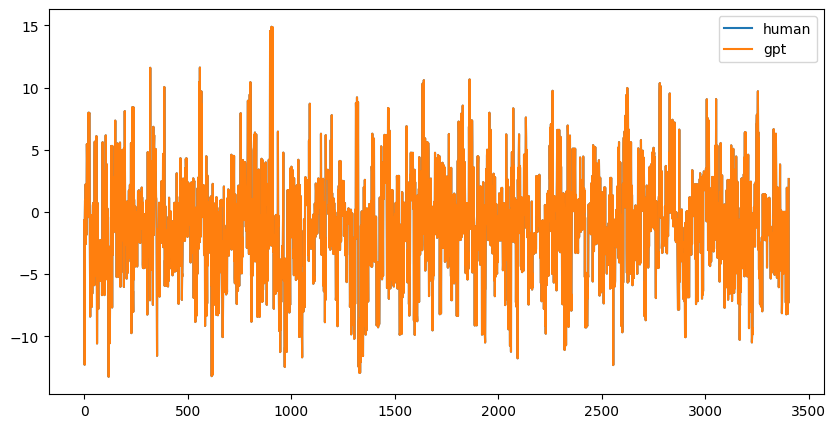

In [28]:
# plot and give different colors
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(gold_scores, label='human')
plt.plot(fim_prob_all, label='gpt')
plt.legend()
plt.show()

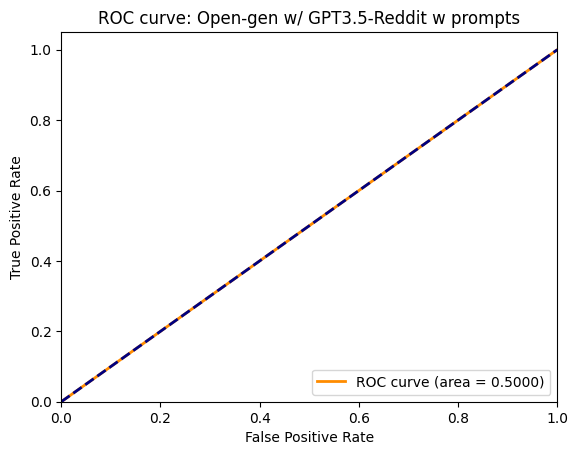

TPR at 1% FPR: 0.1004


(np.float64(0.5), np.float64(0.10044052863436123))

In [29]:
plot_roc_curve( gold_scores, fim_prob_all  )